Regression task: distance modulus vs redshift.

In [193]:
import sklearn
from sklearn.linear_model import LinearRegression
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

import pandas as pd
import numpy as np
import scipy.stats
import pylab as plt
from matplotlib import pyplot as plt
from scipy import stats
import random
import math

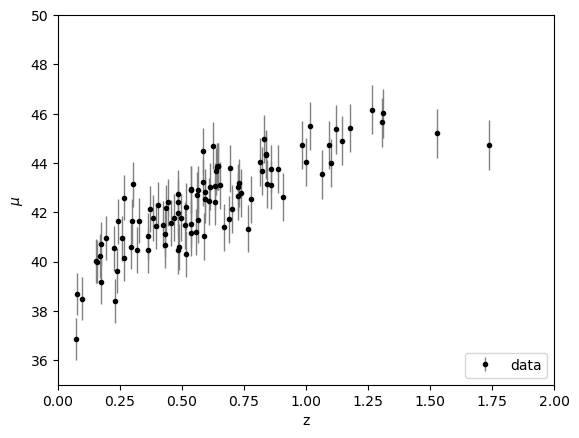

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234) # YOU CANNOT CHANGE THIS

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

In [194]:
x_train, x_test, y_train, y_test, err_train, err_test = train_test_split(z_sample,mu_sample,dmu,train_size=0.9,random_state=42)

# Linear regression

$y_i = \theta_0 + \theta_1x_i$

In [195]:
model = LinearRegression()
model.fit(x_train[:,np.newaxis],y_train,err_train)
print('Score: ', model.score(x_test[:,np.newaxis],y_test))

Score:  0.6615534276526353


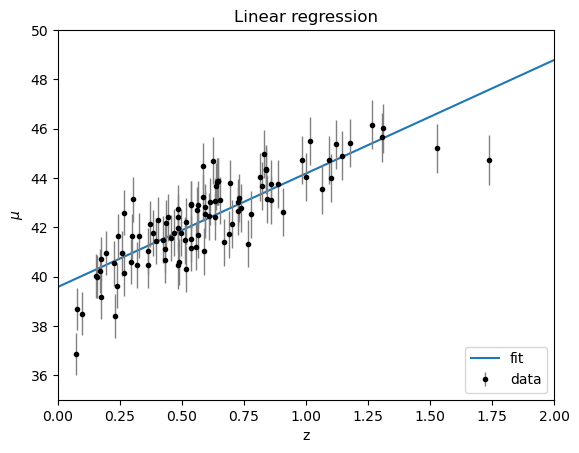

In [196]:
x_plot = np.linspace(0,2,100)
plt.plot(x_plot,model.predict(x_plot[:,np.newaxis]), label='fit')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')

plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.title('Linear regression')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

# Polynomial regression

$y_i = \theta_0 + \theta_1x_i + \theta_2x_i^2 + \theta_3x_i^3 + ...$

Let's fit our data with a polynomial. First, let's do multiple fits changing the degree of the polynomial.

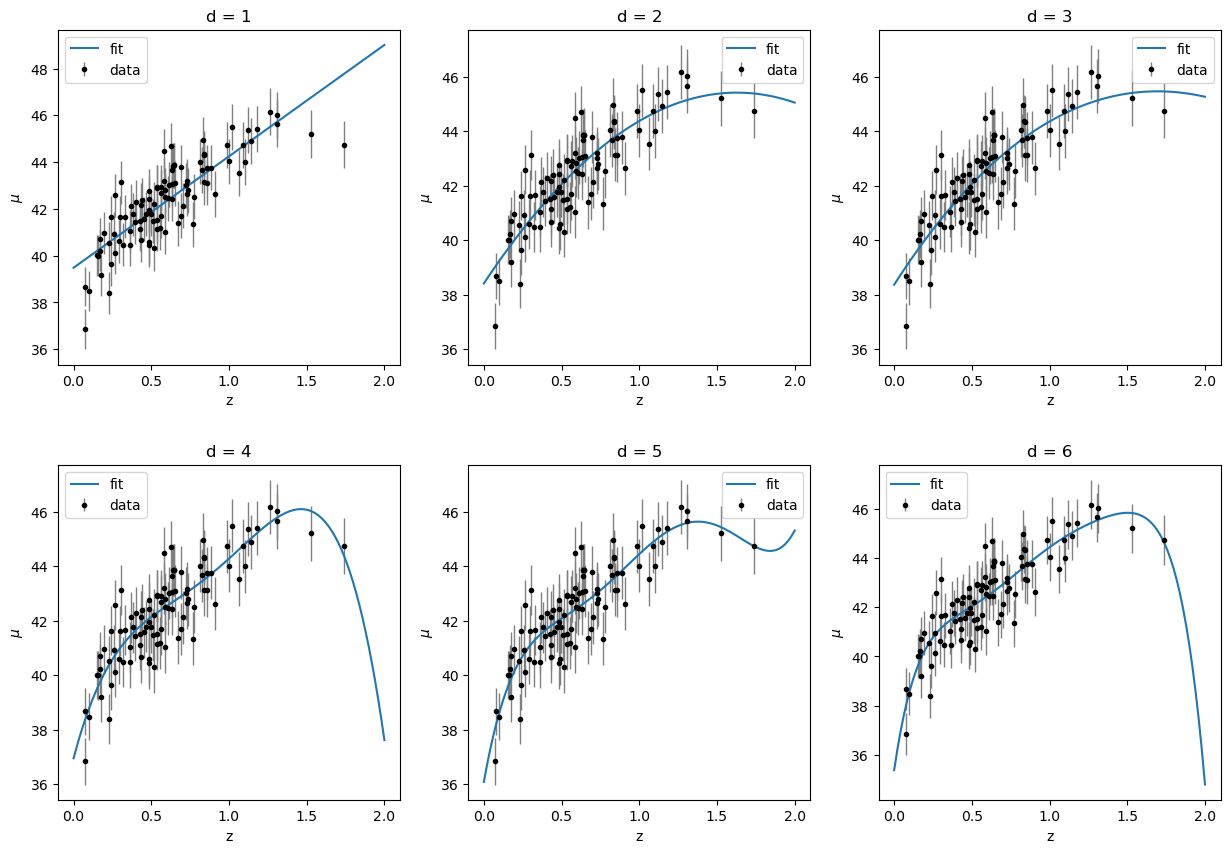

In [197]:
fig, axes = plt.subplots(2,3,figsize=(15,10))
fig.subplots_adjust(hspace= 0.3)

model = PolynomialRegression(1)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
axes[0,0].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[0,0].plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
axes[0,0].set_title('d = 1')
axes[0,0].set_xlabel('z')
axes[0,0].set_ylabel(r"$\mu$")
axes[0,0].legend()

model = PolynomialRegression(2)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
axes[0,1].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[0,1].plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
axes[0,1].set_title('d = 2')
axes[0,1].set_xlabel('z')
axes[0,1].set_ylabel(r"$\mu$")
axes[0,1].legend()

model = PolynomialRegression(3)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
axes[0,2].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[0,2].plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
axes[0,2].set_title('d = 3')
axes[0,2].set_xlabel('z')
axes[0,2].set_ylabel(r"$\mu$")
axes[0,2].legend()

model = PolynomialRegression(4)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
axes[1,0].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[1,0].plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
axes[1,0].set_title('d = 4')
axes[1,0].set_xlabel('z')
axes[1,0].set_ylabel(r"$\mu$")
axes[1,0].legend()

model = PolynomialRegression(5)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
axes[1,1].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[1,1].plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
axes[1,1].set_title('d = 5')
axes[1,1].set_xlabel('z')
axes[1,1].set_ylabel(r"$\mu$")
axes[1,1].legend()

model = PolynomialRegression(6)
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
axes[1,2].errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
axes[1,2].plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
axes[1,2].set_title('d = 6')
axes[1,2].set_xlabel('z')
axes[1,2].set_ylabel(r"$\mu$")
axes[1,2].legend()

plt.show()

It looks likes $d=2$ and $d=3$ are the best fit. With $d=1$ we underfit our data, with $d>3$ we overfit it.
\
The hyperparameter of our fit is the degree $d$ of the polynomial. Let's use cross-validation to tune this hyperparameter.

In [188]:
'''
degree = np.arange(1,50,1,dtype=int)
model = PolynomialRegression()
grid = GridSearchCV(model, {'degree': degree}, scoring = 'r2', cv= 5) # maximise R squared
grid.fit(x_train[:,np.newaxis],y_train)
print('Best iperparameter: ', grid.best_params_)
print('Best score: ', grid.best_score_)
'''

"\ndegree = np.arange(1,50,1,dtype=int)\nmodel = PolynomialRegression()\ngrid = GridSearchCV(model, {'degree': degree}, scoring = 'r2', cv= 5) # maximise R squared\ngrid.fit(x_train[:,np.newaxis],y_train)\nprint('Best iperparameter: ', grid.best_params_)\nprint('Best score: ', grid.best_score_)\n"

In [198]:
def error(x,y,model):
    return np.sqrt(np.sum((y - model.predict(x))**2)/len(y))

def cross_lin(data,labels,err,d):
    kf = KFold(n_splits=5,shuffle=True,random_state=42)
    model = PolynomialRegression(d)
    
    train_err = []
    cross_err = []
    
    for train, test in kf.split(data):
        model.fit(data[train][:,np.newaxis],labels[train],err[train])
        train_err.append(error(data[train][:,np.newaxis],labels[train],model))
        cross_err.append(error(data[test][:,np.newaxis],labels[test],model))
        
    return np.sum(train_err)/len(train_err), np.sum(cross_err)/len(cross_err)

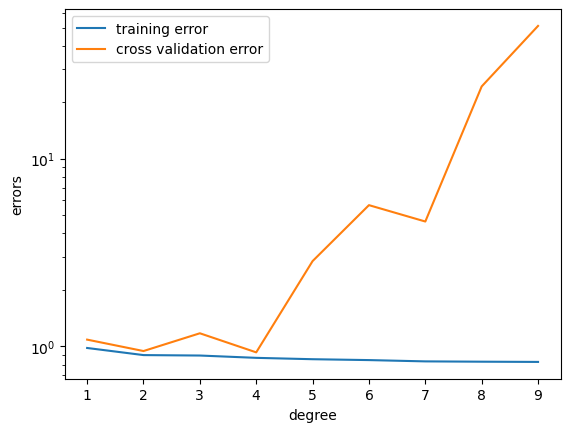

In [200]:
degree = np.arange(1,10,1,dtype=int)
train_err = []
cross_err = []

for d in degree:
    t, c = cross_lin(x_train,y_train,err_train,d)
    train_err.append(t)
    cross_err.append(c)
 
plt.plot(degree,train_err,label='training error')
plt.plot(degree,cross_err,label='cross validation error')
plt.legend()
plt.xlabel('degree')
plt.ylabel('errors')
plt.yscale('log')
plt.show()

In [201]:
degree[cross_err==np.min(cross_err)][0]

4

So, $d=4$ is the value that maximises the score. Let's check the performance of our algorithm on the test set and plot our final fit.

In [202]:
model = PolynomialRegression(degree[cross_err==np.min(cross_err)][0])
model.fit(x_train[:,np.newaxis], y_train, err_train)
y_pred = model.predict(x_test[:,np.newaxis])
print('Score: ', metrics.r2_score(y_test,y_pred))

Score:  0.7097796479680148


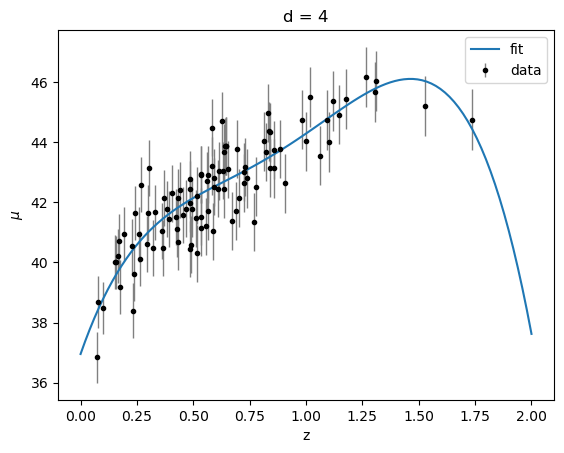

In [204]:
model = PolynomialRegression(degree[cross_err==np.min(cross_err)][0])
model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
plt.title('d = '+str(degree[cross_err==np.min(cross_err)][0]))
plt.xlabel('z')
plt.ylabel(r"$\mu$")
plt.legend()
plt.show()

Let's plot the learning curves.

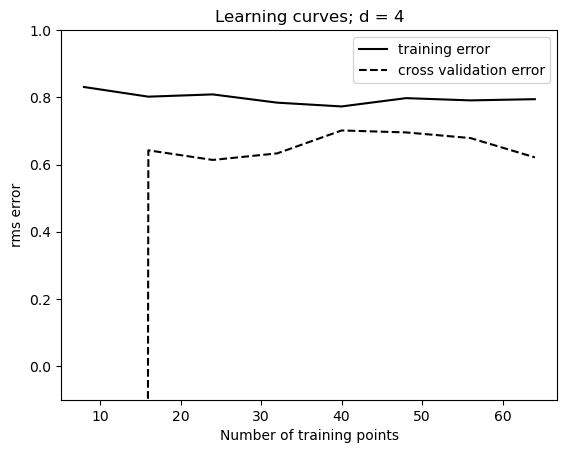

In [207]:
model = PolynomialRegression(degree[cross_err==np.min(cross_err)][0])
train_size = np.arange(0.1,0.9,0.1)
train_sizes_abs, train_scores, test_scores = learning_curve(model,z_sample[:,np.newaxis],mu_sample,train_sizes=train_size,cv=5,scoring='r2',shuffle=True,random_state=42)
plt.plot(train_sizes_abs, np.median(train_scores,1), 'k-', label='training error')
plt.plot(train_sizes_abs, np.median(test_scores,1), 'k--', label='cross validation error')
plt.legend()
plt.xlabel('Number of training points')
plt.ylabel('rms error')
plt.title('Learning curves; d = '+str(degree[cross_err==np.min(cross_err)][0]))
plt.ylim(-0.1,1)
plt.show()

# Basis Function Regression

We choose a gaussian basis. Let's use cross-validation to tune the hyperparameters: the number of gaussians and their $\sigma$.

In [208]:
def error(x,y,model):
    return np.sqrt(np.sum((y - model.predict(x))**2)/len(y))

def cross_basis(data,labels,err,basis,sigma):
    kf = KFold(n_splits=5,shuffle=True,random_state=42)
    mu = np.linspace(np.min(data),np.max(data),basis)[:,None]
    model = BasisFunctionRegression('gaussian',mu=mu,sigma=sigma)
    
    train_err = []
    cross_err = []
    
    for train, test in kf.split(data):
        model.fit(data[train][:,np.newaxis],labels[train],err[train])
        train_err.append(error(data[train][:,np.newaxis],labels[train],model))
        cross_err.append(error(data[test][:,np.newaxis],labels[test],model))
        
    return np.sum(train_err)/len(train_err), np.sum(cross_err)/len(cross_err)

In [209]:
basis = np.arange(1,20,1,dtype=int)
sigma = np.arange(0.01,5,0.1)

train_err = []
cross_err = []
param = []

for b in basis:
    for s in sigma:
        param.append([b,s])
        t, c = cross_basis(x_train,y_train,err_train,b,s)
        train_err.append(t)
        cross_err.append(c)

In [210]:
param = np.array(param)
best = param[cross_err==np.min(cross_err)][0]
best

array([2.  , 0.81])

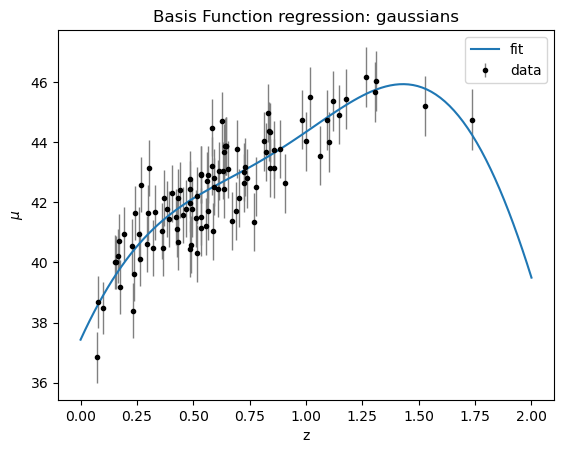

In [211]:
mu = np.linspace(np.min(z_sample),np.max(z_sample),int(best[0]))[:,None]
sigma = best[1]
model = BasisFunctionRegression('gaussian',mu=mu,sigma=sigma)
model.fit(z_sample[:,np.newaxis],mu_sample,dmu)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
plt.title('Basis Function regression: gaussians')
plt.xlabel('z')
plt.ylabel(r"$\mu$")
plt.legend()
plt.show()

In [212]:
model = BasisFunctionRegression(basis_func='gaussian',mu=mu,sigma=sigma)
model.fit(x_train[:,np.newaxis], y_train)
y_pred = model.predict(x_test[:,np.newaxis])
print('Score: ', metrics.r2_score(y_test,y_pred))

Score:  0.7107219030420775


# Kernel Regression

We choose a gaussian kernel. Let's use cross-validation to tune the hyperparameter: the bandwidth of the kernel.

In [213]:
def error(x,y,model):
    return np.sqrt(np.sum((y - model.predict(x))**2)/len(y))
    
def cross_kernel(data,labels,err,h):
    kf = KFold(n_splits=5,shuffle=True,random_state=42)
    model = NadarayaWatson(kernel='gaussian', h=h)

    train_err = []
    cross_err = []
    
    for train, test in kf.split(data):
        model.fit(data[train][:,np.newaxis],labels[train],err[train])
        train_err.append(error(data[train][:,np.newaxis],labels[train],model))
        cross_err.append(error(data[test][:,np.newaxis],labels[test],model))
        
    return np.sum(train_err)/len(train_err), np.sum(cross_err)/len(cross_err)

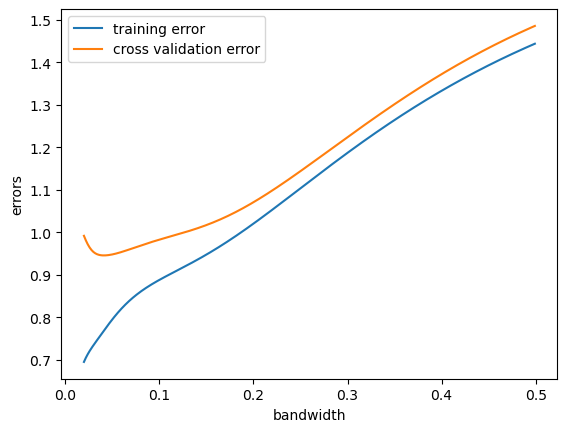

In [214]:
h = np.arange(0.02,0.5,0.001)
train_err = []
cross_err = []

for width in h:
    t, c = cross_kernel(x_train,y_train,err_train,width)
    train_err.append(t)
    cross_err.append(c)
 
plt.plot(h,train_err,label='training error')
plt.plot(h,cross_err,label='cross validation error')
plt.legend()
plt.xlabel('bandwidth')
plt.ylabel('errors')
plt.show()

In [215]:
h[cross_err==np.min(cross_err)]

array([0.041])

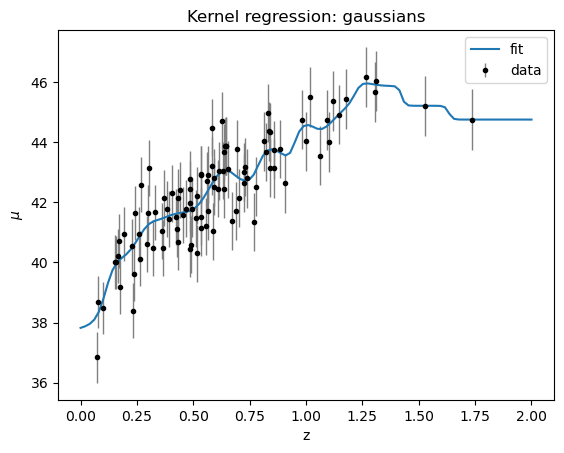

In [216]:
model = NadarayaWatson(kernel='gaussian', h=h[cross_err==np.min(cross_err)])
model.fit(z_sample[:,np.newaxis],mu_sample,dmu)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(x_plot,model.predict(x_plot[:,np.newaxis]),label='fit')
plt.title('Kernel regression: gaussians')
plt.xlabel('z')
plt.ylabel(r"$\mu$")
plt.legend()
plt.show()

Looks like we are overfitting! The cross validation error is indeed higher than the trining error.